## Nội dung chi tiết của model_evaluation.ipynb:

###  Import các thư viện cần thiết:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import sys
# Thêm thư mục chứa scripts vào sys.path
scripts_path = r"C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\scripts"
sys.path.append(scripts_path)

# Thử import class TradingEnv từ scripts.environment
from environment import TradingEnv


###  Tải dữ liệu thử nghiệm:

In [2]:
# Đường dẫn tới dữ liệu thử nghiệm
data_path = r"C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\data\processed\du_lieu_phan_tich\2015\du_lieu_vang_phan_tich_2015_01.csv"
print(data_path)

# Đọc dữ liệu
test_data = pd.read_csv(data_path)
print(test_data.head())


C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\data\processed\du_lieu_phan_tich\2015\du_lieu_vang_phan_tich_2015_01.csv
   Unnamed: 0             datetime      open      high       low     close  \
0          49  2015-01-02 01:49:00  1186.291  1186.313  1186.117  1186.154   
1          50  2015-01-02 01:50:00  1186.154  1186.626  1186.072  1186.591   
2          51  2015-01-02 01:51:00  1186.591  1186.640  1186.536  1186.609   
3          52  2015-01-02 01:52:00  1186.609  1186.609  1186.526  1186.545   
4          53  2015-01-02 01:53:00  1186.545  1186.662  1186.545  1186.642   

   volume        rsi      macd  macd_signal  ...  low_diff        tr   c_DM  \
0       1  49.199450  0.038536     0.074961  ...     0.074  1186.154  0.000   
1       2  57.255833  0.063620     0.072693  ...    -0.045  1186.591  0.313   
2       3  57.554426  0.083983     0.074951  ...     0.464  1186.609  0.000   
3       3  56.055052  0.093875     0.078736  ...    -0.010  1186.545  0.000   
4  

### Tải mô hình đã huấn luyện:

In [3]:
# Đường dẫn tới mô hình
model_path = r"C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\models\ppo_trading_xauusd.zip"
# Kiểm tra sự tồn tại của mô hình
if os.path.exists(model_path):
    model = PPO.load(model_path)
    print(f"Mô hình đã được tải từ: {model_path}")
else:
    raise FileNotFoundError("Mô hình không tồn tại. Vui lòng huấn luyện mô hình trước.")


Mô hình đã được tải từ: C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\models\ppo_trading_xauusd.zip


### Thiết lập môi trường giao dịch:

In [4]:
# Tạo môi trường giao dịch từ dữ liệu thử nghiệm
env = DummyVecEnv([lambda: TradingEnv(test_data, render_mode=None)])


###  Đánh giá mô hình:

In [5]:
# Khởi tạo biến để lưu kết quả
obs = env.reset()
total_rewards = []
total_profit = 0
num_trades = 0

# Duyệt qua tập dữ liệu thử nghiệm
for i in range(len(test_data) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    
    # Ghi nhận lợi nhuận và số lần giao dịch
    total_rewards.append(rewards)
    if done:
        obs = env.reset()

# Tổng lợi nhuận
total_profit = sum(total_rewards)
print(f"Tổng lợi nhuận: {total_profit}")


Tổng lợi nhuận: [-14348.]


## Tính toán các chỉ số hiệu suất:

### `Sharpe Ratio:`

In [6]:
# Tính Sharpe Ratio
daily_returns = np.array(total_rewards)
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(len(daily_returns))
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: -14349.002856550173


### `Tỷ lệ thắng/thua:`

In [7]:
# Tỷ lệ thắng/thua
wins = len([r for r in total_rewards if r > 0])
losses = len([r for r in total_rewards if r < 0])
win_rate = wins / (wins + losses)
print(f"Tỷ lệ thắng: {win_rate * 100:.2f}%")


Tỷ lệ thắng: 0.00%


## Trực quan hóa kết quả:

### `Biểu đồ lợi nhuận theo thời gian:`

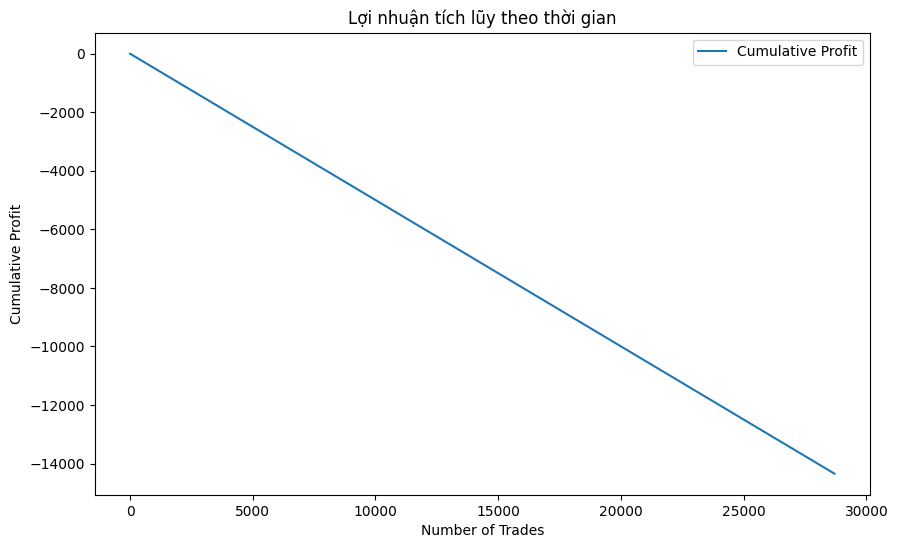

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(total_rewards), label="Cumulative Profit")
plt.xlabel("Number of Trades")
plt.ylabel("Cumulative Profit")
plt.title("Lợi nhuận tích lũy theo thời gian")
plt.legend()
plt.show()


### `Phân phối lợi nhuận:`

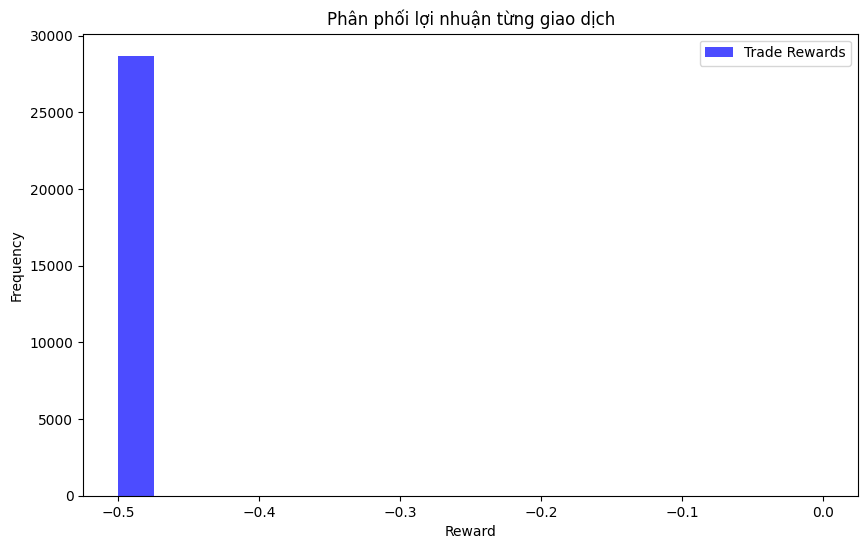

In [11]:
flattened_rewards = np.concatenate(total_rewards).flatten()

# Vẽ biểu đồ histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_rewards, bins=20, alpha=0.7, color='blue', label='Trade Rewards')
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Phân phối lợi nhuận từng giao dịch")
plt.legend()
plt.show()


## Lưu kết quả đánh giá:

In [13]:
# Lưu kết quả vào tệp CSV
evaluation_results = {
    'Total Profit': [total_profit],
    'Sharpe Ratio': [sharpe_ratio],
    'Win Rate': [win_rate]
}
results_df = pd.DataFrame(evaluation_results)

# Đường dẫn tuyệt đối
results_path = r"C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\results\evaluation_results.csv"

# Lưu tệp kết quả
results_df.to_csv(results_path, index=False)
print(f"Kết quả đánh giá đã được lưu tại: {results_path}")


Kết quả đánh giá đã được lưu tại: C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\results\evaluation_results.csv
